<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment2/Assignment_2_MLP_tf_Srinath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)



#Change the directory

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
working_directory = '/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/Second_Assignment'
if os.getcwd() !=  working_directory:
  os.chdir(working_directory)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/OVGU/Deep_Learning/Second_Assignment'

#import statements

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Task -1 (MLP Script using tf.data)

##Load Data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Visualize some images on some training and test data

1


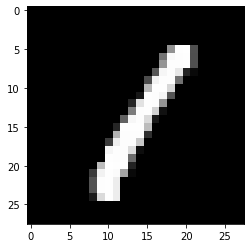

In [ ]:
print(train_labels[3])
plt.imshow(train_images[3], cmap="Greys_r")

4


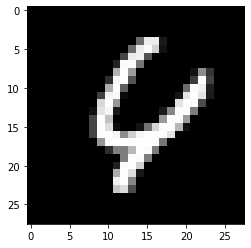

In [ ]:
print(test_labels[121])
plt.imshow(test_images[121], cmap="Greys_r")

## Pre-process the data



### reshape the data, normalize the input images of uni8  to 0-1 int

In [ ]:
def preprocess_images(images):
    return images.reshape(-1, 784).astype(np.float32) / 255

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_labels = preprocess_labels(train_labels)
test_labels = preprocess_labels(test_labels)

### Shuffle, Batch, Repeat 

1.   Shuffle the data, supported parameter buffer size
2.   can create the batches of data
3.   repeat how many times the data should be repeated , default value is every time create new dataset when the current one is completed

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(60000).batch(128).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

##A function that will choose the activation function

In [ ]:
def dynamicActiFunc(actFun, currLogits):
  if actFun == "relu":
    return tf.nn.relu(currLogits)
  elif actFun == "lrelu":
    return tf.nn.leaky_relu(currLogits)
  elif actFun == "sigmoid":
    return tf.nn.sigmoid(currLogits)
  else:
    return tf.nn.relu(currLogits)

##Define a Generic function for training

Observations:


1.   Logging weights and biases for every step consumes so much power, so commented and looged for every 100 steps


Note:- Logs can be viewed from tensorboard



In [ ]:
def model_Train(_modelConfig):
  logdir = os.path.join("logs", "model" + str(_modelConfig["number"]) + str(datetime.now()))
  train_writer = tf.summary.create_file_writer(os.path.join(logdir, "train"))
  test_writer = tf.summary.create_file_writer(os.path.join(logdir, "test"))

  for step, (image_batch, label_batch) in enumerate(train_data):
      if step > _modelConfig["train_steps"]:
        break

      with tf.GradientTape() as tape:
          #loop that will goes forward for every hidden layer
          for ind in range(len(_modelConfig["_weights"])-1):
            if ind == 0:
              hPrevLogits = tf.matmul(image_batch, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
              hPrevOutput = dynamicActiFunc(_modelConfig["activation_func"], hPrevLogits)
            else :
              hcurrLogits = tf.matmul(hPrevOutput, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
              hcurrOutput = dynamicActiFunc(_modelConfig["activation_func"], hcurrLogits)
              hPrevOutput = hcurrOutput

          lastInd = len(_modelConfig["_weights"])-1

          #final output layer
          logits = tf.matmul(hcurrOutput, _modelConfig["_weights"][lastInd]) + _modelConfig["_biases"][lastInd]
          xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
              logits=logits, labels=label_batch))
          
      grads = tape.gradient(xent, [*_modelConfig["_weights"], *_modelConfig["_biases"]])

      #update weights
      for ind in range(len(_modelConfig["_weights"])):
        _modelConfig["_weights"][ind].assign_sub(_modelConfig["learning_rate"] * grads[ind])
      
      #update biases
      for ind in range(len(_modelConfig["_biases"])):
        _modelConfig["_biases"][ind].assign_sub(_modelConfig["learning_rate"] * grads[ind + len(_modelConfig["_biases"])])

      # with train_writer.as_default():
      #   tf.summary.scalar("loss", xent, step=step)
      #   tf.summary.histogram("logits", logits, step=step)
      #   for ind in range(len(_modelConfig["_weights"])):
      #     tf.summary.histogram("weights"+str(ind), _modelConfig["_weights"][ind], step=step)
      #     tf.summary.histogram("biases"+str(ind), _modelConfig["_biases"][ind], step=step)


      if not step % 100:
          # print(step)
          preds = tf.argmax(logits, axis=1, output_type=tf.int32)
          acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),
                              tf.float32))
          # print("Loss: {} Accuracy: {}".format(xent, acc))

          with train_writer.as_default():
            tf.summary.scalar("accuracy", acc, step=step)
            tf.summary.scalar("loss", xent, step=step)
            tf.summary.image("input", tf.reshape(image_batch, [-1, 28, 28, 1]), step=step)
            tf.summary.histogram("logits", logits, step=step)
            for ind in range(len(_modelConfig["_weights"])):
              tf.summary.histogram("weights"+str(ind), _modelConfig["_weights"][ind], step=step)
              tf.summary.histogram("biases"+str(ind), _modelConfig["_biases"][ind], step=step)

          #Predict for Test Dataset
          for ind in range(len(_modelConfig["_weights"])-1):
              if ind == 0:
                hPrevLogits_Test = tf.matmul(test_images, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
                hPrevOutput_Test = dynamicActiFunc(_modelConfig["activation_func"], hPrevLogits_Test)
              else :
                hcurrLogits_Test = tf.matmul(hPrevOutput_Test, _modelConfig["_weights"][ind]) + _modelConfig["_biases"][ind]
                hcurrOutput_Test = dynamicActiFunc(_modelConfig["activation_func"], hcurrLogits_Test)
                hPrevOutput_Test = hcurrOutput_Test

          lastInd = len(_modelConfig["_weights"])-1
          test_preds = tf.argmax(tf.matmul(hcurrOutput_Test, _modelConfig["_weights"][lastInd]) + _modelConfig["_biases"][lastInd], axis=1,
                              output_type=tf.int32)
          test_acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels),
                                      tf.float32))
          
          with test_writer.as_default():
                tf.summary.scalar("accuracy", test_acc, step=step)
          # print("\nTest Accuracy: {}".format(test_acc))

##Models Config

###Declartions

In [ ]:
modelConfig1 = {}
modelConfig2 = {}
modelConfig3 = {}
modelConfig4 = {}
modelConfig5 = {}
modelConfig6 = {}
modelConfig7 = {}
modelConfig8 = {}

###Relu Activation Function

####Define params Model1, 2, 3, 4

In [ ]:
def relu_Config_Reset():
    global modelConfig1, modelConfig2, modelConfig3, modelConfig4
    modelConfig1 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "relu",
        "number": 1,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig2 = {
        "train_steps" : 2000,
        "learning_rate" : 0.01,
        "activation_func" : "relu",
        "number": 2,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig3 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "relu",
        "number": 3,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 1568], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([1568, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(1568, dtype=np.float32)),
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig4 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "relu",
        "number": 4,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.15, maxval=0.15, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.15, maxval=0.15, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.15, maxval=0.15, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

###Sigmoid Activation Function

####Define params Models 5, 6, 7, 8

In [ ]:
def sigmoid_Config_Reset():
    global modelConfig5, modelConfig6, modelConfig7, modelConfig8
    modelConfig5 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "sigmoid",
        "number": 5,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig6 = {
        "train_steps" : 2000,
        "learning_rate" : 0.01,
        "activation_func" : "sigmoid",
        "number": 6,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig7 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "sigmoid",
        "number": 7,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 1568], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([1568, 512], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.1, maxval=0.1, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.1, maxval=0.1, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(1568, dtype=np.float32)),
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

    modelConfig8 = {
        "train_steps" : 1000,
        "learning_rate" : 0.1,
        "activation_func" : "sigmoid",
        "number": 8,

        "_weights" : [
            tf.Variable(tf.random.uniform([784, 512], minval=-0.15, maxval=0.15, dtype=np.float32)),
            tf.Variable(tf.random.uniform([512, 256], minval=-0.15, maxval=0.15, dtype=np.float32)),
            tf.Variable(tf.random.uniform([256, 10], minval=-0.15, maxval=0.15, dtype=np.float32))
        ],

        "_biases" : [
            tf.Variable(np.zeros(512, dtype=np.float32)),
            tf.Variable(np.zeros(256, dtype=np.float32)),
            tf.Variable(np.zeros(10, dtype=np.float32))
        ]
    }

##Models Training

###Relu Models Training

In [ ]:
relu_Config_Reset()

print("Model1 Start")
model_Train(modelConfig1)
print("Model1 End")
print("\n")

print("Model2 Start")
model_Train(modelConfig2)
print("Model2 End")
print("\n")

print("Model3 Start")
model_Train(modelConfig3)
print("Model3 End")
print("\n")

print("Model4 Start")
model_Train(modelConfig4)
print("Model4 End")
print("\n")

Model1 Start
Model1 End


Model2 Start
Model2 End


Model3 Start
Model3 End


Model4 Start
Model4 End




###Sigmoid Models Training

In [ ]:
sigmoid_Config_Reset()

print("Model5 Start")
model_Train(modelConfig5)
print("Model5 End")
print("\n")

print("Model6 Start")
model_Train(modelConfig6)
print("Model6 End")
print("\n")

print("Model7 Start")
model_Train(modelConfig7)
print("Model7 End")
print("\n")

print("Model8 Start")
model_Train(modelConfig8)
print("Model8 End")
print("\n")

Model5 Start
Model5 End


Model6 Start
Model6 End


Model7 Start
Model7 End


Model8 Start
Model8 End




##Tensor board

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs

# Task - 2






## A description of what the six shuffle/batch/repeat orderings do (on a conceptual level) and which one you think is the most sensible for training neural networks

### Explanations



1.   tf.data.shuffle basically shuffles the data, it buffer size as parameter, meaning if the the tensor contains 1000 values and buffer size is 100 then it shuffles first 100(from 1- 100) at one time and next time (2 -101)... so on.
2.   tf.data.batch divides the dataset into the supplied number of batches.
3.   tf.data.repeat generates specified number of times the dataset, if we want to train our model with 30 epochs, then it generates 30 times the same dataset.... important thing to be noted is it will not generate the next dataset until the current one is completed.

The best ordering would be shuffle then repeat (1, 2, 3) or (1, 3, 2).

Shuffle, then repeat guarantees that all samples will be processed before the next repeat begins whereas otherway,all samples might not be processed in one epoch.



# Task -3 (Script1 Explanation)

## Observations

###First observation is the logits computation in the following code snippet


```
def model_forward(inputs):
    x = inputs
    for w, b in layers[:-1]:
        x = tf.nn.relu(tf.matmul(x, w) + b)
    
    #Old code
    logits = tf.matmul(x, layers[-1][0] + layers[-1][1])

    #Updated code
    logits = tf.matmul(x, layers[-1][0]) + layers[-1][1]

    return logits
```

###Second observation is that it is running one layer less, because there are no output layer weights, biases appended to the layers list



```
w_out = tf.Variable(tf.random.uniform([n_units, 10], -w_range, w_range),
                    name="wout")
b_out = tf.Variable(tf.zeros(10), name="bout")

#Added Code
layers.append([w_out, b_out])
```

###Third observation, even after correcting the respected above observations still the model has not improved. So the main problem which we think is weights initialisation.


1.   We have changed the weights range from [-0.4, 0.4] to [-0.1, 0.1] and then accuracy has improved to 89%.
2.   The other option which we tried was keeping the weight range same and decreasing the deep model layers to 4, training steps to 2000 and still the accuracy has improved a lot to 94%. The reason why we think is that multiplication factor in earlier case was too much since it has 8 layers( May be we think it is out of float scope). now the multiplication factor is better but still the number is less so it is taking long time to learn.
3.  Reduce the learning rate to 0.0001 so that when it is back propagating, if the gradients are so high then the updation will not have negative values
4. The gradients are exploding after the 2nd iteration itself





# Task -3 (Script2 Explanation)

## Observations


1.   First two observations from the above script are same
2.   Third observation is it is using sigmoid function as an activation function, the values that are being supplied to sigmoid function are very small negative values and it is getting saturated, close to 0 values. The accuracy was 11%
3. We tried by changing the hidden layer size(8 to 2) then it works, because in the earlier case it was multiplication so the values are bigger. The accuracy was 87%




## write

# Task -3 (Script3 Explanation)

## Observations


1.   First two observations from the first script are same
2.   Third observation is it is using relu as an activation funtion and since the weights range lie between [0, -0.1] the activation function is making them 0, so there is no learning and the loss remains same. The accuracy was 11%
3. The solutions could be by changing the activation function to leaky relu or change the weights range. The accuracy has changed to 87% in leaky relu

# Task -3 (Script4 Explanation)

## Observations


1.   First two observations from the first script are same
2.   We tried by plotting the images after the noise addition of standard deviation 2, for the number 2 it is impossible to identify with human eyes that it is 2(Too much noise). The accuracy was 80%

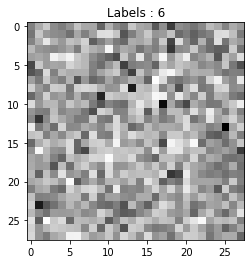

3.  When the standard deviation is reduced to 0.1 then the image is identifiable and the accuracy has improved. The accuracy was 95.8%
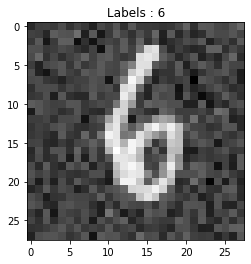

# Task -3 (Script5 Explanation)

## Observations


1.   First two observations from the first script are same
2.   Third observation is that softmax is being applied to the logits before supplying them to the cross entropy calculation and also applying during the cross entropy calculation. Solution is to to remove the softmax during logits computation.
3. for example if we apply softmax on [2,3,4] the output values are [0.04,0.11,0.84] and now if we apply softmax again on this [0.04,0.11,0.84] then the output values are [0.23,0.24,0.51]. Even though the highlest probability remains same, but the loss decreases when it computes by applying softmax 2 times and may need more time to converge.


#References


1.   https://ovgu-ailab.github.io/idl2021/assignments/2/linear_tb.ipynb
2.   https://ovgu-ailab.github.io/idl2021/assignments/2/tf_data.ipynb

